First we load the functions and libraries necessary for this report.

In [18]:
from __future__ import print_function
from lightfm import LightFM

import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
run analysis_functions.ipynb #import all helper functions

For initial analysis, we will explore and model data from only 9000 users. In future sections we will extend this model to more users. 

In [20]:
# Import main dataset
df = pd.read_csv('lastfm_9000_users.csv', na_filter=False)
df = df.drop(['Unnamed: 0'], axis=1)

The structure of the analysis will be as such: 
0. Data Exploration
1. Objective
2. Prepare data
3. Model Fitting, Tuning, and Evaluation
    - Benchmarks
        - Most Popular
        - ALS Matrix Factorization (Implicit)
        - Bayesian Personalized Ranking (Implicit)
    - LightFM
        - FM without Side Info (Vanilla)
        - FM with User/Item Side Information
        - Parameter Tuning
    - Summary of Results between Models (Table)
4. Model Exploration
    - Metrics Used (Recall, Precision, Coverage)
    - Metrics by User Segments 
        - Active/Non-Active
        - Diverse/Non-Diverse 
        - Mainstream/Non-Mainstream 
    - Scale
        - Metrics by Size
        - Training Time / Predict Time by Size
    - Qualitative Results (Serendipity/Novelty)
6. Conclusion / Next Steps

# 0. Data Exploration

Before we dive into modeling, let's take a look at what data currently looks like. 

In [21]:
df.head()

,user_id,artist_mbid,artist_name,plays
0,00029d80b8af94f2d5e3349ceb28b7304f80c1c4,b7ffd2af-418f-4be2-bdd1-22f8b48613da,nine inch nails,11092
1,00029d80b8af94f2d5e3349ceb28b7304f80c1c4,8ca01f46-53ac-4af2-8516-55a909c0905e,my bloody valentine,1671
2,00029d80b8af94f2d5e3349ceb28b7304f80c1c4,e795e03d-b5d5-4a5f-834d-162cfb308a2c,pj harvey,1603
3,00029d80b8af94f2d5e3349ceb28b7304f80c1c4,69ee3720-a7cb-4402-b48d-a02c366f2bcf,the cure,1588
4,00029d80b8af94f2d5e3349ceb28b7304f80c1c4,90cc2464-234e-4da0-b39b-576f36e633bc,antony and the johnsons,1039


Next lets take a first, high-level look at the datset.

In [22]:
df.describe()

,plays
count,438346.000000
mean,216.435998
std,800.547832
min,1.000000
25%,34.000000
50%,94.000000
75%,225.000000
max,242328.000000


In [23]:
df.describe(include = 'O')

,user_id,artist_mbid,artist_name
count,438346,438346,438346
unique,9000,47102,53577
top,1a0cefc82b7f7566d12b69697ea91a29b20f6554,,radiohead
freq,107,5731,1926


It's interesting to see that there are more artist names than artist mbid. This is probably because some artist names share the same mbid (seen below), due to both error and if the same artist have different names. **To distinguish between artists, we will then use artist_mbid.** FERNANDO NEED CODE HERE

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438346 entries, 0 to 438345
Data columns (total 4 columns):
user_id        438346 non-null object
artist_mbid    438346 non-null object
artist_name    438346 non-null object
plays          438346 non-null int64
dtypes: int64(1), object(3)
memory usage: 13.4+ MB


Let's see if there's any missing values within the dataset.

In [25]:
df.isna().sum()

user_id        0
artist_mbid    0
artist_name    0
plays          0
dtype: int64

Let's see if there's any wrong values in the datset.

In [26]:
print('Wrong Values:\n=============')
print('User Id: ', df.loc[df.user_id == ''].shape[0])
print('Artist MBID: ', df.loc[df.artist_mbid == ''].shape[0])
print('Artist Name: ', df.loc[df.artist_name == ''].shape[0])
print('Plays: ', df.loc[df.plays < 0].shape[0])

Wrong Values:
User Id:  0
Artist MBID:  5731
Artist Name:  6
Plays:  0


It looks like there are some invalid values for mbid and name. Let's take a look at them:

In [27]:
len(df.loc[df.artist_mbid == ''])/len(df)

0

These values are only 1% of the dataset, so for sake of simplicity let us just drop these values. 

In [28]:
df = df[df.artist_mbid != '']
df = df[df.artist_name != '']

In [29]:
#sanity check
print('Wrong Values:\n=============')
print('User Id: ', df.loc[df.user_id == ''].shape[0])
print('Artist MBID: ', df.loc[df.artist_mbid == ''].shape[0])
print('Artist Name: ', df.loc[df.artist_name == ''].shape[0])
print('Plays: ', df.loc[df.plays < 0].shape[0])

Wrong Values:
User Id:  0
Artist MBID:  0
Artist Name:  0
Plays:  0


Next, let's see how the number of plays are distributed within the data.

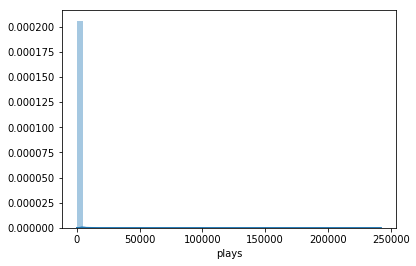

In [30]:
sns.distplot(df.plays)

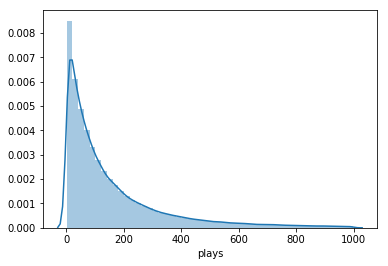

In [31]:
sns.distplot(df[df.plays < 1000].plays)

It's interesting to see how the data is exponentially distributed as shown above. The packages we use should have already accounted for such an imbalance, but in case they don't, let's scale these values.

In [32]:
from sklearn.preprocessing import MinMaxScaler 

df['log_plays'] = df.plays.apply(lambda x: log(x))

df.log_plays *= (1.0/df.log_plays.max())

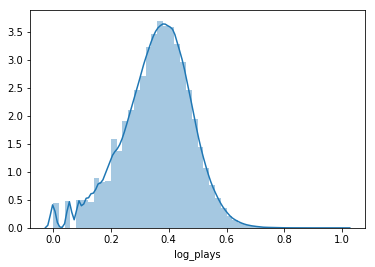

In [33]:
sns.distplot(df.log_plays)

# 1. Objective

The objective for this project is similar as before: to build a reliable recommender system that generates new and relevant artist recommendations to Last.fm users. We will do this by recommending the top-k (e.g. top 20) artists for each user. Each recommendation is personalized to each user and is ‘learnt’ from his or her listening habits and history. The business objective of our recommender system is to increase user activity in Last.fm and user loyalty to the Last.fm brand by providing a service that allows users to discover new artists and have a more enjoyable listening experience. This model is similar to Spotify's "Discover Weekly", but on an artist basis

# 2. Prepare Data

Let's first transform the dataset above to a format that is consumable by the Implicit and LightFM model.

### 2a. Create Sparse Matrix from Dataset

In [34]:
#create sparse matrix
plays_sparse = create_sparse_matrix(df).astype('float')
print('Matrix Sparsity:', calculate_sparsity(plays_sparse))

Creating sparse matrix...


/Users/TimGimi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
/Users/TimGimi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


Matrix Sparsity: 99.8979362887


### 2b. Split Data to Train/Test

Split data into train test set, maintaining that each user still has some interactions intact. This custom split train test is only used for the **implicit** package. 

In [35]:
# Split data into training and test sets
train, test, user_count = split_train_test_per_user(plays_sparse, k = 3, interactions = 10)
print("Percentage of original data masked:", pct_masked(plays_sparse, train.T.tocsr()))
print("Users masked:", user_count)


Percentage of original data masked: 0.0663708633759
Users masked: 8975


Note that the train is in the form of item by user, to accomodate the implicit and baseline models.

In [36]:
train

<47100x8999 sparse matrix of type '<type 'numpy.float64'>'
	with 432600 stored elements in Compressed Sparse Row format>

### 2c. Build Interactions for LightFM

For lightFM, we would need a different kind of format for the datasets. We create them using LightFM's data builders below.

In [37]:
import lightfm
from lightfm.data import Dataset
from lightfm import cross_validation

# Initialize lightfm Dataset()
int_df = df.drop(['artist_name', 'log_plays'], axis=1)
int_data = lightfm.data.Dataset(user_identity_features=True, item_identity_features=True)

# Create tuples for int_df values, as well as separate tuples for user_id and artist_id
tuples = [tuple(x) for x in int_df.values]
user_id = [tuple(x) for x in df.user_id]
artist_id = [tuple(x) for x in df.artist_mbid]

# Fit int_data
int_data.fit(df.user_id, df.artist_mbid)

# Build interactions, weights
interactions, weights = int_data.build_interactions(tuples)

# Create training and test sets for lightFM
train_light, test_light = lightfm.cross_validation.random_train_test_split(plays_sparse, test_percentage=0.6, random_state=None)

In [23]:
test_light

<8999x47100 sparse matrix of type '<class 'numpy.float64'>'
	with 259560 stored elements in COOrdinate format>

In [24]:
train_light

<8999x47100 sparse matrix of type '<class 'numpy.float64'>'
	with 173040 stored elements in COOrdinate format>

# 3. Model Fitting, Tuning, and Evaluation

Next, we set up our models to perform recommendations on the Lastfm datasets. Compared to our previous attempt, we will now use a more sophisticated take on building a recommendation engine: Factorization Machines (FM). Our motivation in using FMs is to utilize the side information we have on users (age, gender, etc.) to improve our metrics. We decided to use LightFM's implementation of FMs due to its known efficiency and good results. Our benchmarks to beat will be the "most popular" model and the ALS Implicit Matrix Factorization.

For Baseline and Implicit models, we will be focusing on the following metrics:
1. Recall at k 
2. Precision at k 
3. NDCG at k 
4. Coverage

We define recall@k as: the number of positive items in the first k positions of the ranked list of results divided by the number of positive items in the test period.

We define precision@k as: the fraction of known positives in the first k positions of the ranked list of results.

For the LightFM models, we will be using:
1. Recall at k 
2. Precision at k
3. Coverage

NDCG isn't covered in LightFM models since it is not supported within the LightFM package. Furthermore, our attempt at calculating NDCG on our own did not turn out as expected, as the results did not make sense (much lower than recall @ k). 

## 3a. Benchmarks

### Baseline: Most Popular

The "baseline" recommends the most-popular artists to everyone, regardless of their play history. Implementation of the baseline model can be found in analysis_functions.ipynb. (To do: refactor models to separate Python scripts).

In [42]:
model_baseline = Baseline(n_recs = 20)
model_baseline.fit(train)

Fitting baseline...


No tuning is necessary since there are no parameters. We then evaluate the test set below: 

In [26]:
coverage, precision, recall, ndcg = evaluate(model_baseline, "baseline", test, plays_sparse)
print("Precision:",precision*100,'%')
print("Recall:",recall*100,'%')
print("Coverage:",coverage*100,'%')
print("Average NDCG per User:",ndcg*100,'%')

final_results = {}
final_results['model'] = ['baseline']
final_results['precision (%)'] = [precision*100]
final_results['recall (%)'] = [recall*100]
final_results['coverage (%)'] = [coverage*100]
final_results['ndcg (%)'] = [ndcg*100]


Evaluating model...



Precision: 0.9961002785515319 %
Recall: 6.64066852367688 %
Coverage: 0.042462845010615716 %
Average NDCG per User: 4.060053351196404 %


### Model-Based (ALS)

Here we fit the model-based ALS Matrix Factorization using the implicit package from our past assignment and use the parameters that were found to be optimized in the HW 2 report. 

In [27]:
model_als = implicit.als.AlternatingLeastSquares(factors = 30, regularization = 0.01)

# Train model
print("Fitting model...")
model_als.fit(train)

  7%|▋         | 1.0/15 [00:00<00:01,  9.21it/s]

Fitting model...


100%|██████████| 15.0/15 [00:01<00:00, 10.20it/s]


In [28]:
coverage, precision, recall, ndcg = evaluate(model_als, "implicit", test, train.T.tocsr())
print("Precision:",precision*100,'%')
print("Recall:",recall*100,'%')
print("Coverage:",coverage*100,'%')
print("Average NDCG per User:",ndcg*100,'%')

final_results['model'].append('als')
final_results['precision (%)'].append(precision*100)
final_results['recall (%)'].append(recall*100)
final_results['coverage (%)'].append(coverage*100)
final_results['ndcg (%)'].append(ndcg*100)


Evaluating model...



Precision: 3.2930362116991643 %
Recall: 21.953574744661093 %
Coverage: 8.530785562632696 %
Average NDCG per User: 0.0 %


### Bayesian Personalized Ranking (Implicit)

Since in lightFM we will mainly be focused on using the bpr loss function, we will also implement Implicit's BPR model as a point of comparison. 

In [29]:
model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors = 30, regularization = 0.01)

# Train model
print("Fitting model...")
model_bpr.fit(train)

coverage, precision, recall, ndcg = evaluate(model_bpr, "implicit", test, plays_sparse)
print("Precision:",precision*100,'%')
print("Recall:",recall*100,'%')
print("Coverage:",coverage*100,'%')
print("Average NDCG per User:",ndcg*100,'%')

final_results['model'].append('bpr')
final_results['precision (%)'].append(precision*100)
final_results['recall (%)'].append(recall*100)
final_results['coverage (%)'].append(coverage*100)
final_results['ndcg (%)'].append(ndcg*100)


  2%|▏         | 2/100 [00:00<00:04, 20.27it/s, correct=50.49%, skipped=2.17%]

Fitting model...


100%|██████████| 100/100 [00:05<00:00, 19.62it/s, correct=94.06%, skipped=2.14%]

Evaluating model...



Precision: 3.395543175487465 %
Recall: 22.63695450324977 %
Coverage: 12.265392781316347 %
Average NDCG per User: 13.02686127201435 %


### LightFM (without side information)

First, we fit the LightFM model without using side information, in the hopes of replicating the results of the MF models above. 

In [30]:
model_fm_vanilla = LightFM(learning_rate=0.05, loss='bpr')

#train model
print("Fitting model...")
model_fm_vanilla.fit(train_light)

#evaluate model
coverage, precision, recall = evaluate_lightfm(model_fm_vanilla, interactions, train_light, test_light)
print("Precision:",precision*100,'%')
print("Recall:",recall*100,'%')
print("Coverage:",coverage*100,'%')

Fitting model...
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
Precision: 0.7503334898501635 %
Recall: 0.512035792205329 %
Coverage: 0.09129511677282379 %


### Troubleshooting

Shoot. It looks like our model does not replicate the results of the Implicit model. Assuming that those two results should've resulted in similar metrics, let's try a few approaches to try to improve the lightfm model.

#### Normalizing / Scaled Train-Test

First, let's use the normalized dataset to train and predict instead. 

In [31]:
df_log = df.drop(columns = ['plays'], axis = 1)
# plays_sparse = create_sparse_matrix(df).astype('float')

df_log.columns = ['user_id','artist_mbid','artist_name','plays']

#create sparse matrix
plays_sparse_log = create_sparse_matrix(df_log).astype('float')
print('Matrix Sparsity:', calculate_sparsity(plays_sparse_log))

train_log, test_log = lightfm.cross_validation.random_train_test_split(plays_sparse_log, test_percentage=0.7)

model_fm_vanilla = LightFM(learning_rate=0.05, loss='bpr')

#train model
print("Fitting model...")
model_fm_vanilla.fit(train_log, epochs=10)

#evaluate model
coverage, precision, recall = evaluate_lightfm(model_fm_vanilla, plays_sparse_log, train_log, test_log)
print("Precision:",precision*100,'%')
print("Recall:",recall*100,'%')
print("Coverage:",coverage*100,'%')

Creating sparse matrix...


/home/tim_kartawijaya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
/home/tim_kartawijaya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


Matrix Sparsity: 99.89885948639257
Fitting model...
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
Precision: 5.299022421240807 %
Recall: 3.129300387887679 %
Coverage: 0.7197452229299364 %


### Checking Convergence

Hmm.. that didn't fix much. Let's see if some of our metrics converge as its training and check if the training is what's the problem. Lets see if user embeddings change by epoch / recall converges by epoch. 

In [32]:
from lightfm.evaluation import recall_at_k

recall_epoch = []
user_embeddings = []
epochs = 30
for epoch in tqdm(range(epochs)):
    model_fm_vanilla.fit_partial(train_light, epochs = 1)
    recall_epoch.append(recall_at_k(model_fm_vanilla, test_light, train_light, k = 20))
    user_embeddings.append(model_fm_vanilla.get_user_representations())
    

In [39]:
recall_avg_epoch = [np.mean(x) for x in recall_epoch]

Text(0,0.5,'Recall')

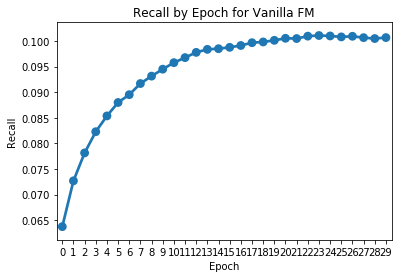

In [40]:
sns.pointplot(x = list(range(epochs)), y = recall_avg_epoch)
plt.title('Recall by Epoch for Vanilla FM')
plt.xlabel('Epoch')
plt.ylabel('Recall')

So from the results above we can see that recall eventually converges after 20 epochs. So this looks fine. 

In [48]:
user_vectors = [x[1] for x in user_embeddings]

In [57]:
user_vectors[4].shape

(8999, 10)

#### TODO: What behavior should user vectors do?

Text(0,0.5,'Recall')

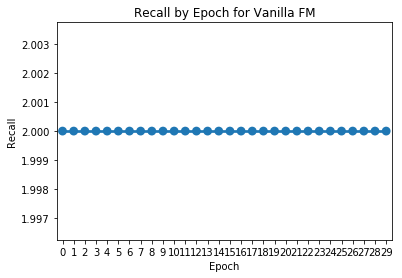

In [45]:
sns.pointplot(x = list(range(epochs)), y = user_embedding_size)
plt.title('Recall by Epoch for Vanilla FM')
plt.xlabel('Epoch')
plt.ylabel('Recall')

### Hyperparameter

Now we try to find the best hyperparameter for this model and use the model with the best hyperparameter to get our results. Maybe tuning our parameters would get us closer to the implicit ALS. 

We first try to tune the dimensionality of the feature embeddings to try to find the best recall, which we consider it important to have at least a few items that the user consider relevant within the top k results. Recall also relates directly to precision and NDCG. At the same time, we would need to consider coverage, as we want to expand the user's tastes as much as we could. 

In [ ]:
test_model = LightFM
params = [15,35,55,75,95]
param_type = "components"
k_fold = 4
n_recs = 20
ndcg_list, heatmap_list = auto_tune_parameter(k = k_fold, interactions = 20, model = test_model, data = plays_sparse, param1 = params, param_type = param_type)

In [ ]:
#Plot Recall by Number of Components
recall_values = heatmap_list[0]

recall_heatmap_components = pd.DataFrame({'N':params, 'Recall': recall_values})
sns.pointplot(x='N',y='Recall',data=recall_heatmap_components)
plt.title('Recall by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Recall')

plt.show()

Next, let's tune the best learning rate.

In [ ]:
model_fm_vanilla = LightFM(learning_rate=0.05, loss='bpr')

#train model
print("Fitting model...")
model_fm_vanilla.fit(train_light)

#evaluate model
coverage, precision, recall = evaluate_lightfm(model_fm_vanilla, interactions, train_light, test_light)
print("Precision:",precision*100,'%')
print("Recall:",recall*100,'%')
print("Coverage:",coverage*100,'%')

test_model = LightFM
params = [0.005, 0.01, 0.05, 0.1, 0.2]
param_type = "learning_rate"
k_fold = 4
n_recs = 20
ndcg_list, heatmap_list = auto_tune_parameter(k = k_fold, interactions = 20, model = test_model, data = plays_sparse, param1 = params, param_type = param_type)

Fitting fold number... 0
Trying  0.005
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
0
Trying  0.01
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
1
Trying  0.05
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
2
Trying  0.1
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...


In [ ]:
#Plot Recall by Number of Components
recall_values = heatmap_list[0]

recall_heatmap_components = pd.DataFrame({'N':params, 'Recall': recall_values})
sns.pointplot(x='N',y='Recall',data=recall_heatmap_components)
plt.title('Recall by Learning Rate')
plt.xlabel('Number of Components')
plt.ylabel('Recall')

plt.show()

Finally, let's see which loss function is better for recall.

In [ ]:
test_model = LightFM
params = ["logistic","bpr","warp"]
param_type = "loss_function"
k_fold = 4
n_recs = 20
ndcg_list, heatmap_list = auto_tune_parameter(k = k_fold, interactions = 20, model = test_model, data = plays_sparse, param1 = params, param_type = param_type)

In [ ]:
#Plot Recall by Number of Components
recall_values = heatmap_list[0]

recall_heatmap_components = pd.DataFrame({'N':params, 'Recall': recall_values})
sns.pointplot(x='N',y='R`ecall',data=recall_heatmap_components)
plt.title('Recall by Number of Components')
plt.xlabel('Loss Function')
plt.ylabel('Recall')

plt.show()

With these hyperparameters above, we would have the final result below.

In [ ]:
model_fm_vanilla = LightFM(learning_rate=0.05, no_components = 50, loss='warp')

#train model
print("Fitting model...")
model_fm_vanilla.fit(train_light, epochs = 25)

#evaluate model
coverage, precision, recall = evaluate_lightfm(model_fm_vanilla, interactions, train_light, test_light)
print("Precision:",precision*100,'%')
print("Recall:",recall*100,'%')
print("Coverage:",coverage*100,'%')

final_results['model'].append('fm_vanilla')
final_results['precision (%)'].append(precision*100)
final_results['recall (%)'].append(recall*100)
final_results['coverage (%)'].append(coverage*100)

### LightFM (with side information)

Next, we will try to fit LightFM with side information and see if it improves our model.

In [46]:
user_feat = pd.read_csv("user_features_9000.csv")
user_feat = user_feat[user_feat.columns[1:]]
user_features = scipy.sparse.csr_matrix(user_feat.values)

In [48]:
model_fm_feat = LightFM(learning_rate=0.05, no_components = 50, loss='warp')

# Train Model
print("Fitting model...")
model_fm_feat.fit(train_light, user_features=user_features, epochs = 25)

coverage, precision, recall = evaluate_lightfm(model_fm_feat, plays_sparse, train_light, test_light, user_features=user_features)
print("Precision:",precision*100,'%')
print("Recall:",recall*100,'%')
print("Coverage:",coverage*100,'%')

final_results['model'].append('fm_with_features')
final_results['precision (%)'].append(precision*100)
final_results['recall (%)'].append(recall*100)
final_results['coverage (%)'].append(coverage*100)

Fitting model...


### Troubleshooting

Shoot. Adding user features doesn't help either. Let's take a look at our user_features and see if there's a problem with it inherently.

In [4]:
col_names = ['user_id','sex','age','country','dob']
data_raw = pd.read_csv("user_side_data_raw.tsv", sep = "\t", header = None, names = col_names)
data_raw.head()

,user_id,sex,age,country,dob
0,00000c289a1829a808ac09c00daf10bc3c4e223b,f,22.0,Germany,"Feb 1, 2007"
1,00001411dc427966b17297bf4d69e7e193135d89,f,NaN,Canada,"Dec 4, 2007"
2,00004d2ac9316e22dc007ab2243d6fcb239e707d,NaN,NaN,Germany,"Sep 1, 2006"
3,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,m,19.0,Mexico,"Apr 28, 2008"
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.0,United States,"Jan 27, 2006"


In [5]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359347 entries, 0 to 359346
Data columns (total 5 columns):
user_id    359347 non-null object
sex        326572 non-null object
age        284447 non-null float64
country    359347 non-null object
dob        359347 non-null object
dtypes: float64(1), object(4)
memory usage: 13.7+ MB


In [6]:
data_raw.isna().sum()

user_id        0
sex        32775
age        74900
country        0
dob            0
dtype: int64

~9% of sex is null

In [9]:
data_raw.isna().sum().sex/float(data_raw.user_id.unique().shape[0])

0.09120710622323269

~21% of age is null/below 10

In [10]:
(data_raw.isna().sum().age + data_raw[data_raw.age < 10].shape[0])/float(data_raw.user_id.unique().shape[0])


0.21171736510949027

In [11]:
data_raw.describe()

,age
count,284447.000000
mean,25.098046
std,21.665742
min,-1337.000000
25%,20.000000
50%,23.000000
75%,28.000000
max,1002.000000


As we can see above, the user_data is not perfect and we have a significant null value for ages and also gender. Even if we combine these null values as "other" category, it does not improve the model. Let's see later if having more data would increase accuracy.

TO DO: if have enough time, find best hyperparameter for this FM model too.

In [34]:
# testmodel=LightFM
# tries=[9,10,11,12]
# start = time.time()
# ndcg_list,heatmap_list=auto_tune_parameter(4,20,testmodel,plays_sparse,tries,user_features=user_features,item_features=None)
# stop = time.time()
# total = stop-start

In [ ]:
# #Plot Recall by Number of Components
# recall_values=heatmap_list[0]
# # Plot NDCG by Activity Level
# recall_heatmap_components = pd.DataFrame({'N':tries, 'Recall': recall_values})
# sns.pointplot(x='N',y='Recall',data=recall_heatmap_components)
# plt.title('Recall by Number of Components')
# plt.xlabel('Number of Components')
# plt.ylabel('Recall')

# plt.show()

### Summary of Performance Results (Table)

We summarize the results below for both Implicit and LightFM models:

In [ ]:
pd.DataFrame.from_dict(final_results)

# 4. Model Exploration

Next, we explore these models even more. How do they perform in regards to size, different user population? In our exploration we will focus on three user segments:
1. **Activity**: users that have a large number of plays vs those that do not.

2. **Diversity**: users that listen to a large number of artists equally vs those that listen only to a specific set of artists. We measure diversity by attaching a diversity score to each user, which is calculated by the spread of listens across all artists played. The artist plays for each user is scaled to between 0 and 1, where 1 is attached to the artist with the most number of plays for that user. The score is then computed by taking the sum of these scaled values. This means that users who have listened to more artists generally have a higher diversity score. Furthermore, it also means that users whose artist plays are more evenly spread out have a higher diversity score as well. For example, a user with [500, 1, 1, 1] listens will have a lower score than a user with [200, 50, 150, 125] listens.

3. **Mainstreamness**: users that listen only to popular artists at the time vs. none who do. We measure how ‘mainstream’ each user is by similarly attaching to them a score, which is determined by their weighted plays of popular artists. We first compute the popularity of each artist by calculating their respective total plays across all users. Following which, we assign an indicator for how mainstream a user is by computing the weighted total of listens to the top n artists. n is a parameter that we can tune to adjust which artists are considered ‘popular’.


## 4a. Performance by User Type

In [ ]:
#import functions to group users by different segments.

In [86]:
run grouping_functions.ipynb

### Active/Non-Active

In [87]:
import seaborn as sns

In [88]:
n=3
activity_groups=active_users(plays_sparse, n)
levels=[1,2,3]
recall_activity_als = []
precision_activity_als = []
coverage_activity_als = []

recall_activity_baseline = []
precision_activity_baseline = []
coverage_activity_baseline = []

recall_activity_fm = []
precision_activity_fm = []
coverage_activity_fm = []

for group in activity_groups:
    #print('Matrix Sparsity:', calculate_sparsity(group))
    # Compute the recall and ndcg using optimal parameters for the ALS model on different dataset sizes
    train, test, user_count = split_train_test_per_user(group, 4, 20)
    # train model 
    print("Fitting model...")
    #FIRST, BASELINE------------------------------
    model=Baseline(20)
    model.fit(train)
    coverage, precision, recall, ndcg = evaluate(model,"baseline", test, group)

    recall_activity_baseline.append(recall)
    precision_activity_baseline.append(precision)
    coverage_activity_baseline.append(coverage)
    
    #SECOND, ALS-------------------------------------
    model = implicit.als.AlternatingLeastSquares(factors=30, regularization=0.01)
    model.fit(train, show_progress=True)
    
    coverage, precision, recall, ndcg = evaluate(model,"implicit", test, group)

    recall_activity_als.append(recall)
    precision_activity_als.append(precision)
    coverage_activity_als.append(coverage)
    
    #THIRD, LIGHTFM----------------------------------
    train_light_plot, test_light_plot = lightfm.cross_validation.random_train_test_split(group, test_percentage=0.75, random_state=None)
    model = LightFM(no_components=50, loss='warp')
    model.fit(train_light_plot, user_features=user_features,epochs=25)
    coverage, precision, recall = evaluate_lightfm(model, group, train_light_plot, test_light_plot, user_features=user_features)

    recall_activity_fm.append(recall)
    precision_activity_fm.append(precision)
    coverage_activity_fm.append(coverage)

Fitting model...
Fitting baseline...
Evaluating model...


100%|██████████| 15.0/15 [00:02<00:00,  6.83it/s]

Evaluating model...


Evaluating LightFM...
Calculating Coverage...


Calculating Recall at k...
Calculating Precision at k...


Fitting model...
Fitting baseline...
Evaluating model...


100%|██████████| 15.0/15 [00:02<00:00,  7.94it/s]

Evaluating model...


Evaluating LightFM...
Calculating Coverage...


Calculating Recall at k...
Calculating Precision at k...


Fitting model...
Fitting baseline...
Evaluating model...


100%|██████████| 15.0/15 [00:01<00:00,  7.85it/s]

Evaluating model...


Evaluating LightFM...
Calculating Coverage...


Calculating Recall at k...
Calculating Precision at k...


/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


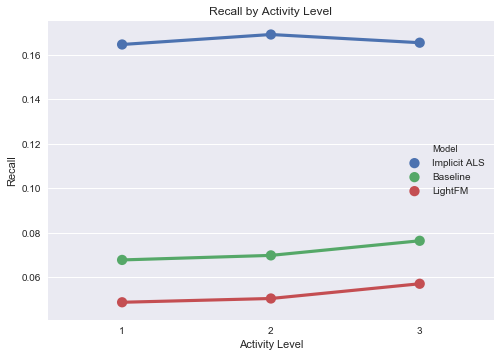

In [89]:
# Plot Recall by Activity Level
recall_activity_als_df = pd.DataFrame({'N':levels, 'Recall': recall_activity_als})
recall_activity_baseline_df = pd.DataFrame({'N':levels, 'Recall': recall_activity_baseline})
recall_activity_fm_df = pd.DataFrame({'N':levels, 'Recall': recall_activity_fm})

f, ax = plt.subplots(1, 1)

recall_activity_als_df['Model'] = 'Implicit ALS'
recall_activity_baseline_df['Model'] = 'Baseline'
recall_activity_fm_df['Model'] = 'LightFM'

df = pd.concat([recall_activity_als_df,recall_activity_baseline_df,recall_activity_fm_df])
sns.pointplot(ax=ax,x='N',y='Recall',data=df,hue='Model')
plt.title('Recall by Activity Level')
plt.xlabel('Activity Level')
plt.ylabel('Recall')

plt.show()

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


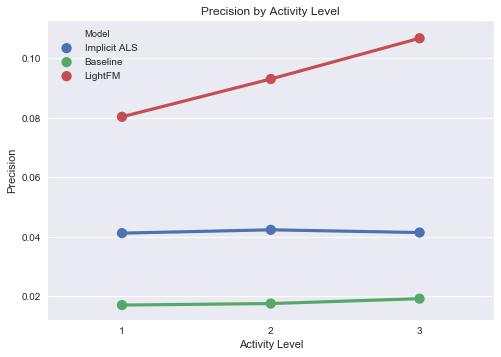

In [90]:
# Plot Precision by Activity Level
precision_activity_als_df = pd.DataFrame({'N':levels, 'Precision': precision_activity_als})
precision_activity_baseline_df = pd.DataFrame({'N':levels, 'Precision': precision_activity_baseline})
precision_activity_fm_df = pd.DataFrame({'N':levels, 'Precision': precision_activity_fm})
f, ax = plt.subplots(1, 1)

precision_activity_als_df['Model'] = 'Implicit ALS'
precision_activity_fm_df['Model'] = 'LightFM'
precision_activity_baseline_df['Model'] = 'Baseline'
df = pd.concat([precision_activity_als_df,precision_activity_baseline_df,precision_activity_fm_df])
sns.pointplot(ax=ax,x='N',y='Precision',data=df,hue='Model')
plt.title('Precision by Activity Level')
plt.xlabel('Activity Level')
plt.ylabel('Precision')

plt.show()

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


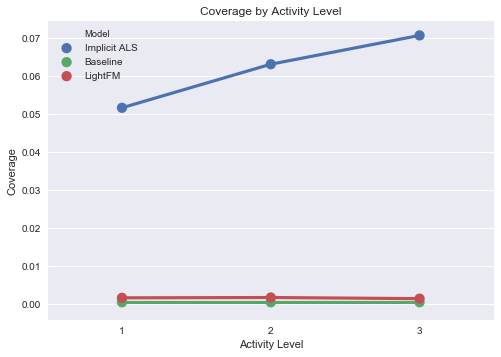

In [91]:
# Plot Coverage by Activity Level
coverage_activity_als_df = pd.DataFrame({'N':levels, 'Coverage': coverage_activity_als})
coverage_activity_baseline_df = pd.DataFrame({'N':levels, 'Coverage': coverage_activity_baseline})
coverage_activity_fm_df = pd.DataFrame({'N':levels, 'Coverage': coverage_activity_fm})

f, ax = plt.subplots(1, 1)

coverage_activity_als_df['Model'] = 'Implicit ALS'
coverage_activity_baseline_df['Model'] = 'Baseline'
coverage_activity_fm_df['Model'] = 'LightFM'
df = pd.concat([coverage_activity_als_df,coverage_activity_baseline_df,coverage_activity_fm_df])
sns.pointplot(ax=ax,x='N',y='Coverage',data=df,hue='Model')
plt.title('Coverage by Activity Level')
plt.xlabel('Activity Level')
plt.ylabel('Coverage')

plt.show()

### Diverse/Non-Diverse

In [94]:
n=3
diversity_groups=diverse_users(plays_sparse, n)
levels=[1,2,3]
recall_div_als = []
precision_div_als = []
coverage_div_als = []

recall_div_baseline = []
precision_div_baseline = []
coverage_div_baseline = []

recall_div_fm = []
precision_div_fm = []
coverage_div_fm = []

for group in diversity_groups:
    #print('Matrix Sparsity:', calculate_sparsity(group))
    # Compute the recall and ndcg using optimal parameters for the ALS model on different dataset sizes
    train, test, user_count = split_train_test_per_user(group, 4, 20)
    # train model 
    print("Fitting model...")
    #FIRST, BASELINE------------------------------
    model=Baseline(20)
    model.fit(train)
    coverage, precision, recall, ndcg = evaluate(model,"baseline", test, group)

    precision_div_baseline.append(precision)
    coverage_div_baseline.append(coverage)
    recall_div_baseline.append(recall)

    
    #SECOND, ALS-------------------------------------
    model = implicit.als.AlternatingLeastSquares(factors=30, regularization=0.01)
    model.fit(train, show_progress=True)
    
    coverage, precision, recall, ndcg = evaluate(model,"implicit", test, group)

    recall_div_als.append(recall)
    precision_div_als.append(precision)
    coverage_div_als.append(coverage)
    
    #THIRD, LIGHTFM-----------------------------------
    train_light_plot, test_light_plot = lightfm.cross_validation.random_train_test_split(group, test_percentage=0.75, random_state=None)
    model = LightFM(no_components=50, loss='warp')
    model.fit(train_light_plot, user_features=user_features,epochs=25)
    coverage, precision, recall = evaluate_lightfm(model, group, train_light_plot, test_light_plot, user_features=user_features)

    recall_div_fm.append(recall)
    precision_div_fm.append(precision)
    coverage_div_fm.append(coverage)

Fitting model...
Fitting baseline...
Evaluating model...


100%|██████████| 15.0/15 [00:01<00:00,  8.48it/s]

Evaluating model...


Evaluating LightFM...
Calculating Coverage...


Calculating Recall at k...
Calculating Precision at k...


Fitting model...
Fitting baseline...
Evaluating model...


100%|██████████| 15.0/15 [00:02<00:00,  6.86it/s]

Evaluating model...


Evaluating LightFM...
Calculating Coverage...


Calculating Recall at k...
Calculating Precision at k...


Fitting model...
Fitting baseline...
Evaluating model...


100%|██████████| 15.0/15 [00:02<00:00,  6.52it/s]

Evaluating model...


Evaluating LightFM...
Calculating Coverage...


Calculating Recall at k...
Calculating Precision at k...


/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


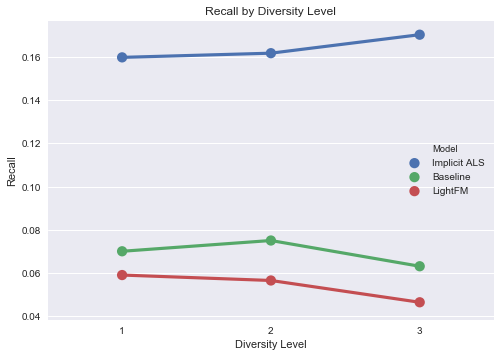

In [95]:
# Plot Recall by Diversity Level
recall_div_als_df = pd.DataFrame({'N':levels, 'Recall': recall_div_als})
recall_div_baseline_df = pd.DataFrame({'N':levels, 'Recall': recall_div_baseline})
recall_div_fm_df = pd.DataFrame({'N':levels, 'Recall': recall_div_fm})

f, ax = plt.subplots(1, 1)

recall_div_als_df['Model'] = 'Implicit ALS'
recall_div_baseline_df['Model'] = 'Baseline'
recall_div_fm_df['Model'] = 'LightFM'
df = pd.concat([recall_div_als_df,recall_div_baseline_df,recall_div_fm_df])
sns.pointplot(ax=ax,x='N',y='Recall',data=df,hue='Model')
plt.title('Recall by Diversity Level')
plt.xlabel('Diversity Level')
plt.ylabel('Recall')

plt.show()

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


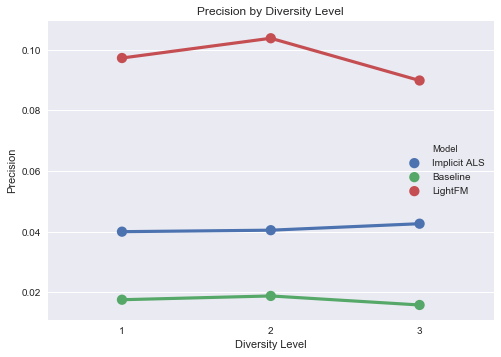

In [96]:
# Plot Precision by Diversity Level
precision_div_als_df = pd.DataFrame({'N':levels, 'Precision': precision_div_als})
precision_div_baseline_df = pd.DataFrame({'N':levels, 'Precision': precision_div_baseline})
precision_div_fm_df = pd.DataFrame({'N':levels, 'Precision': precision_div_fm})

f, ax = plt.subplots(1, 1)

precision_div_als_df['Model'] = 'Implicit ALS'
precision_div_baseline_df['Model'] = 'Baseline'
precision_div_fm_df['Model'] = 'LightFM'

df = pd.concat([precision_div_als_df,precision_div_baseline_df,precision_div_fm_df])
sns.pointplot(ax=ax,x='N',y='Precision',data=df,hue='Model')
plt.title('Precision by Diversity Level')
plt.xlabel('Diversity Level')
plt.ylabel('Precision')

plt.show()

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


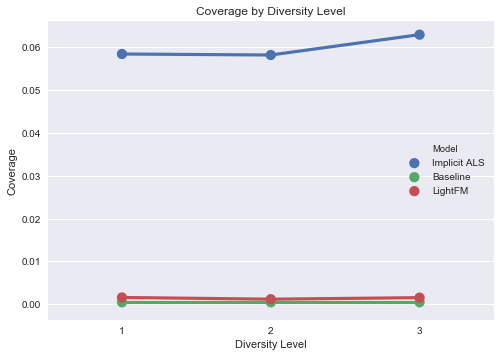

In [97]:
# Plot Coverage by Diversity Level
coverage_div_als_df = pd.DataFrame({'N':levels, 'Coverage': coverage_div_als})
coverage_div_baseline_df = pd.DataFrame({'N':levels, 'Coverage': coverage_div_baseline})
coverage_div_fm_df = pd.DataFrame({'N':levels, 'Coverage': coverage_div_fm})

f, ax = plt.subplots(1, 1)

coverage_div_als_df['Model'] = 'Implicit ALS'
coverage_div_baseline_df['Model'] = 'Baseline'
coverage_div_fm_df['Model'] = 'LightFM'

df = pd.concat([coverage_div_als_df,coverage_div_baseline_df,coverage_div_fm_df])
sns.pointplot(ax=ax,x='N',y='Coverage',data=df,hue='Model')
plt.title('Coverage by Diversity Level')
plt.xlabel('Diversity Level')
plt.ylabel('Coverage')

plt.show()

### Mainstream / Non-Mainstream

In [98]:
n=3
ms_groups=mainstream_users(plays_sparse, top_artists=20, n=3)
levels=[1,2,3]
recall_ms_als = []
precision_ms_als = []
coverage_ms_als = []

recall_ms_baseline = []
precision_ms_baseline = []
coverage_ms_baseline = []

recall_ms_fm = []
precision_ms_fm = []
coverage_ms_fm = []

for group in ms_groups:
    #print('Matrix Sparsity:', calculate_sparsity(group))
    # Compute the recall and ndcg using optimal parameters for the ALS model on different dataset sizes
    train, test, user_count = split_train_test_per_user(group, 4, 20)
    # train model 
    print("Fitting model...")
    #FIRST, BASELINE------------------------------
    model=Baseline(20)
    model.fit(train)
    coverage, precision, recall, ndcg = evaluate(model,"baseline", test, group)

    recall_ms_baseline.append(recall)
    precision_ms_baseline.append(precision)
    coverage_ms_baseline.append(coverage)
    
    #SECOND, ALS-------------------------------------
    model = implicit.als.AlternatingLeastSquares(factors=30, regularization=0.01)
    model.fit(train, show_progress=True)
    
    coverage, precision, recall, ndcg = evaluate(model,"implicit", test, group)

    recall_ms_als.append(recall)
    precision_ms_als.append(precision)
    coverage_ms_als.append(coverage)
    
    #THIRD, LIGHTFM-----------------------------------
    train_light_plot, test_light_plot = lightfm.cross_validation.random_train_test_split(group, test_percentage=0.75, random_state=None)
    model = LightFM(no_components=50, loss='warp')
    model.fit(train_light_plot, user_features=user_features,epochs=25)
    coverage, precision, recall = evaluate_lightfm(model, group, train_light_plot, test_light_plot, user_features=user_features)

    recall_ms_fm.append(recall)
    precision_ms_fm.append(precision)
    coverage_ms_fm.append(coverage)

Fitting model...
Fitting baseline...
Evaluating model...


100%|██████████| 15.0/15 [00:02<00:00,  6.12it/s]

Evaluating model...


Evaluating LightFM...
Calculating Coverage...


Calculating Recall at k...
Calculating Precision at k...


Fitting model...
Fitting baseline...
Evaluating model...


100%|██████████| 15.0/15 [00:02<00:00,  7.83it/s]

Evaluating model...


Evaluating LightFM...
Calculating Coverage...


Calculating Recall at k...
Calculating Precision at k...


Fitting model...
Fitting baseline...
Evaluating model...


100%|██████████| 15.0/15 [00:01<00:00,  9.44it/s]

Evaluating model...


Evaluating LightFM...
Calculating Coverage...


Calculating Recall at k...
Calculating Precision at k...


/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


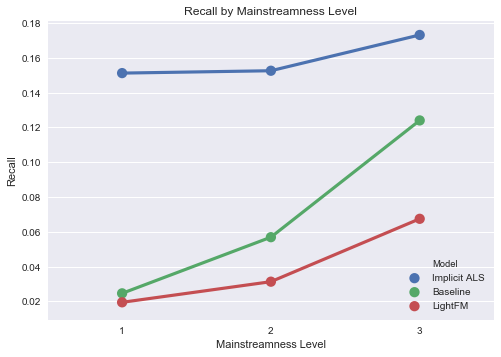

In [99]:
# Plot Recall by Mainstreamness Level
recall_ms_als_df = pd.DataFrame({'N':levels, 'Recall': recall_ms_als})
recall_ms_baseline_df = pd.DataFrame({'N':levels, 'Recall': recall_ms_baseline})
recall_ms_fm_df = pd.DataFrame({'N':levels, 'Recall': recall_ms_fm})

f, ax = plt.subplots(1, 1)

recall_ms_als_df['Model'] = 'Implicit ALS'
recall_ms_baseline_df['Model'] = 'Baseline'
recall_ms_fm_df['Model'] = 'LightFM'

df = pd.concat([recall_ms_als_df,recall_ms_baseline_df,recall_ms_fm_df])
sns.pointplot(ax=ax,x='N',y='Recall',data=df,hue='Model')
plt.title('Recall by Mainstreamness Level')
plt.xlabel('Mainstreamness Level')
plt.ylabel('Recall')

plt.show()

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


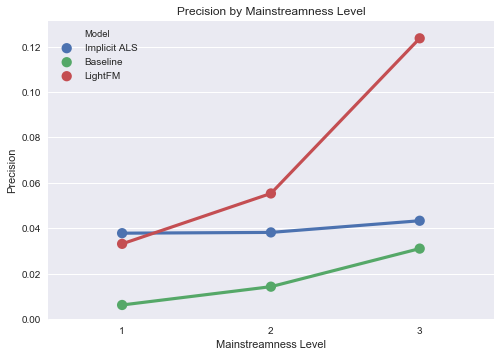

In [100]:
# Plot Precision by Mainstreamness Level
precision_ms_als_df = pd.DataFrame({'N':levels, 'Precision': precision_ms_als})
precision_ms_baseline_df = pd.DataFrame({'N':levels, 'Precision': precision_ms_baseline})
precision_ms_fm_df = pd.DataFrame({'N':levels, 'Precision': precision_ms_fm})

f, ax = plt.subplots(1, 1)

precision_ms_als_df['Model'] = 'Implicit ALS'
precision_ms_baseline_df['Model'] = 'Baseline'
precision_ms_fm_df['Model'] = 'LightFM'

df = pd.concat([precision_ms_als_df,precision_ms_baseline_df,precision_ms_fm_df])
sns.pointplot(ax=ax,x='N',y='Precision',data=df,hue='Model')
plt.title('Precision by Mainstreamness Level')
plt.xlabel('Mainstreamness Level')
plt.ylabel('Precision')

plt.show()

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


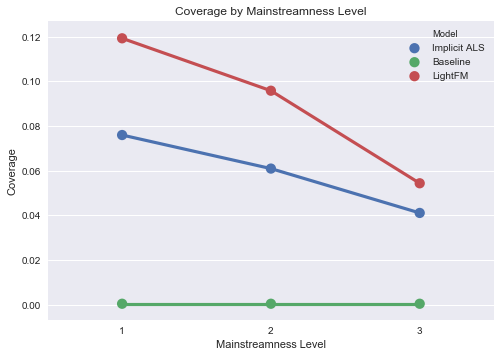

In [101]:
# Plot Coverage by Mainstreamness Level
coverage_ms_als_df = pd.DataFrame({'N':levels, 'Coverage': coverage_ms_als})
coverage_ms_baseline_df = pd.DataFrame({'N':levels, 'Coverage': coverage_ms_baseline})
coverage_ms_fm_df = pd.DataFrame({'N':levels, 'Coverage': coverage_ms_fm})

f, ax = plt.subplots(1, 1)

coverage_ms_als_df['Model'] = 'Implicit ALS'
coverage_ms_baseline_df['Model'] = 'Baseline'
coverage_ms_fm_df['Model'] = 'LightFM'

df = pd.concat([coverage_ms_als_df,coverage_ms_baseline_df,coverage_ms_fm_df])
sns.pointplot(ax=ax,x='N',y='Coverage',data=df,hue='Model')
plt.title('Coverage by Mainstreamness Level')
plt.xlabel('Mainstreamness Level')
plt.ylabel('Coverage')

plt.show()

## 4b. Performance by Input Size 

Next, we will see how our model scales, in regards to accuracy and running time. 

In [ ]:
#import full dataset: you can find data in 
#https://www.dropbox.com/s/nbdeiujmsi9l7ny/lastfm_150k_users.csv.zip?dl=0
df_all = pd.read_csv("lastfm_150k_users.csv")

In [ ]:
#Helper function to sample full dataset
def get_users(df, n):
    sample_userid = df["user_id"].unique()
    sample_userid = np.random.choice(sample_userid, size = n, replace = False)

    #grab rows with sample user id
    df_sample = df[df.user_id.isin(sample_userid)].reset_index(drop = True)

    return df_sample

In [ ]:
sizes = [9000]

precision_all = []
recall_all = []
coverage_all = []
train_time = []
recommend_time = []

for size in sizes: 
    print("Modeling ", size, " users...")
    
    df_sample = get_users(df_all, size)
    df_sample = df_sample.drop(['Unnamed: 0'], axis=1)
    
    #create FM model with tuned parameters
    model_fm = LightFM(learning_rate=0.05, loss='warp')
    
    #create sparse matrix
    plays_sparse = create_sparse_matrix(df_sample)
    print('Matrix Sparsity:', calculate_sparsity(plays_sparse))
    
    #split train test
    train, test = random_train_test_split(plays_sparse)
    
    start = timeit.timeit()
    
    #train model
    print("Fitting model...")
    model_fm.fit(train, epochs = 30)
    
    end = timeit.timeit()
    train_t = end-start
    
    #evaluate model 
    print("Evaluating model...")
    coverage, precision, recall = evaluate_lightfm(model_fm, plays_sparse, train, test)
    print("Precision:",precision*100,'%')
    print("Recall:",recall*100,'%')
    print("Coverage:",coverage*100,'%')
    
    #time recommend time
    start = timeit.timeit()
    
    print("Recommending item...")
    (-model.predict(0,np.arange(original.shape[1]))).argsort()[:20]
    
    end = timeit.timeit()
    
    recommend_t = end-start
    
    precision_all.append(precision)
    recall_all.append(recall)
    coverage_all.append(coverage)
    train_time.append(train_t)
    recommend_time.append(recommend_t)
    
    print("Finish! \n ========================")

In [ ]:
# Plot Training Time by Input Size
als_train_time_df = pd.DataFrame({'N':size, 'NDCG': als_train_time})
base_train_time_df = pd.DataFrame({'N':size, 'NDCG': base_train_time})
fm_train_time_df = pd.DataFrame({'N':size, 'NDCG': fm_train_time})

f, ax = plt.subplots(1, 1)
als_train_time_df['Model'] = 'Implicit ALS'
base_train_time_df['Model'] = 'Baseline'
fm_train_time_df['Model'] = 'Factorization Machine'
df = pd.concat([als_train_time_df,base_train_time_df,fm_train_time_df])
sns.pointplot(ax=ax,x='N',y='NDCG',data=df,hue='Model')
plt.title('Training Time by Input Size for Factorization Machine')
plt.xlabel('Number of Users')
plt.ylabel('Time (s)')

plt.show()

## 4c. Qualitative Results

On top of accuracy metrics, let's see how the recommender system works qualitatively. Since its difficult to quantify serendipity, we also can use this qualitative method to determine serendipity of our model. Below are some "new users" that we create to qualitatively see how our models do. Since we don't have any idea how our data values relates to time, we are won't be able to determine novelty.

In [14]:
#Helper functions to definition
def add_user(data, new_user, value = 1000):
    col_names = ['user_id','artist_mbid','artist_name','plays']
    mbid_dict = pd.Series(data.artist_mbid.values, index = data.artist_name).to_dict()
    final = []
    
    user_name = new_user[0]
    user_artists = new_user[1]
    
    for artist in user_artists:
        final.append([user_name, mbid_dict[artist], artist, value])
    return pd.concat([data, pd.DataFrame(final, columns = col_names)])

def create_artist_mapping(data):
    artists = list(data.artist_mbid.unique())
    artist_categories = data.artist_mbid.astype('category', categories=artists).cat.categories
    name_dict = pd.Series(data.artist_name.values, index = data.artist_mbid).to_dict()
    artist_map = dict((i, name_dict[x]) for (i, x) in enumerate(artist_categories))
    return artist_map

def create_user_mapping(data):
    users = list(data.user_id.unique())
    user_categories = data.user_id.astype('category', categories=users).cat.categories
    user_map = dict((x, i) for (i, x) in enumerate(user_categories))
    return user_map

def get_artist_name(list_idx, artist_mapping):
    return [artist_mapping[idx] for idx in list_idx]

### What is mainstream/popular in this dataset?

First, let's determine qualitatively what artists are most popular at this time in lastFM. It's interesting to note how the most popular artists are mainly rock/alternative rock for this dataset.

In [43]:
artist_mapping = create_artist_mapping(df)
get_artist_name(model_baseline.predict(), artist_mapping)

/Users/TimGimi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  app.launch_new_instance()


['endless blue',
 'miriam stockley',
 'bumblebeez',
 'freak kitchen',
 'new bomb turks',
 'mark isham',
 'mikroboy',
 'tarja',
 'ceremony',
 'joe cocker',
 'clair de lune',
 'the prophet',
 'tacere',
 'junior kelly',
 'the maccabees',
 'julian cope',
 'leniwiec',
 'giuseppe verdi',
 'dj smash',
 'mix master mike']

### New Users

Next, let's create "new users" to see how our model predicts artists for them. Below are some users that are in the different segments above, as well as our own team members to test a sense of serendipity.

In [12]:
#list of artists

#not diverse, mainstream
artists_rock = [
    'the beatles',
    'the rolling stones',
    'led zeppelin',
    'queen',
    'pink floyd',
    'ac/dc',
    'guns n\' roses',
    'aerosmith'
]

artists_rap = [
    'kanye west',
    '2pac',
    'lil wayne',
    'eminem',
    'young jeezy',
    'jay-z',
    'drake'
]

artists_tim = [
    'daft punk',
    'deadmau5',
    'john mayer',
    'hans zimmer',
    'coldplay'
]

# tim's brother
# artists_deus = [
#     'coldplay',
#     'john mayer',
#     'justin timberlake'
# ]

artists_char = [
           'solange', 
           'sufjan stevens',  
           'beirut', 
           'yo la tengo', 
           'little dragon', 
           'crystal castles', 
           'a tribe called quest', 
           'radiohead', 
           'faye wong',
           'the beach boys',
           'van morrison',
           'marvin gaye',
           'whitney houston',
           'kanye west',
           'curtis mayfield',
           '2pac',
           'eagles',
           'david bowie',
           'prince'
]

new_users = [('rap', artists_rap),('rock', artists_rock), ('tim', artists_tim), ('char', artists_char)]

### Implicit

First, let's see how our Implicit ALS model performs in predicting these new users. 

In [38]:
#use implicit to get recommended for users
model_als = implicit.als.AlternatingLeastSquares(factors = 30, regularization = 0.01)

for new in new_users: 
    new_users_df = add_user(df, new, 1000)

    #create mappings
    artist_mapping = create_artist_mapping(new_users_df)
    user_mapping = create_user_mapping(new_users_df)

    plays_sparse = create_sparse_matrix(new_users_df)
    train, test, user_count = split_train_test_per_user(plays_sparse, 3, 10)

    # Train model
    print("Fitting model...")
    model_als.fit(train)

    recs = model_als.recommend(user_mapping[new[0]], train.T.tocsr(), N=20, filter_already_liked_items=True)#, artist_mapping) #returns (item_id, score)
    recs = [x[0] for x in recs]
    
    print("User ", new[0], " :\n", get_artist_name(recs, artist_mapping))

    

/Users/TimGimi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  if sys.path[0] == '':
/Users/TimGimi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  app.launch_new_instance()
/Users/TimGimi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


Creating sparse matrix...


/Users/TimGimi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


  0%|          | 0/15 [00:00<?, ?it/s]


Fitting model...


100%|██████████| 15.0/15 [00:07<00:00,  2.33it/s]


User  rap  :
 ['t.i.', '50 cent', 'ludacris', 'lupe fiasco', 'akon', 'snoop dogg', 'the game', 'nas', 'notorious b.i.g.', 'chamillionaire', 'timbaland', 'nelly', 'bone thugs-n-harmony', 'dmx', 'dr. dre', 'justin timberlake', 't-pain', 'flo rida', 'usher', 'ice cube']
Creating sparse matrix...


  0%|          | 0/15 [00:00<?, ?it/s]


Fitting model...


100%|██████████| 15.0/15 [00:08<00:00,  1.98it/s]


User  rock  :
 ['red hot chili peppers', 'nirvana', 'the doors', 'u2', 'muse', 'r.e.m.', 'radiohead', 'bob dylan', 'metallica', 'coldplay', 'the who', 'the white stripes', 'deep purple', 'foo fighters', 'jimi hendrix', 'green day', 'the killers', 'johnny cash', 'the cure', 'david bowie']
Creating sparse matrix...


  0%|          | 0/15 [00:00<?, ?it/s]


Fitting model...


100%|██████████| 15.0/15 [00:07<00:00,  2.13it/s]


User  tim  :
 ['soundtrack', 'linkin park', 'kanye west', 'keane', 'black eyed peas', 'the killers', 'the prodigy', 'jack johnson', 'red hot chili peppers', 'blink-182', 'foo fighters', 'the beatles', 'david guetta', 'oasis', 'frank sinatra', 'u2', 'enya', 'dj ti\xc3\xabsto', 'muse', 'michael jackson']
Creating sparse matrix...


  0%|          | 0/15 [00:00<?, ?it/s]


Fitting model...


100%|██████████| 15.0/15 [00:06<00:00,  2.32it/s]

User  char  :
 ['peter fox', 'mando diao', 'clueso', 'beatsteaks', 'deichkind', 'the beatles', 'die fantastischen vier', 'b\xc3\xb6hse onkelz', 'coldplay', 'tocotronic', 'k.i.z.', 'jan delay', 'blumentopf', 'arctic monkeys', 'the killers', 'radiohead', 'the kooks', 'the white stripes', 'pink floyd', 'prinz pi']


### LightFM

Next, let's see how lightFM with user features performs. 

In [40]:
#use implicit to get recommended for users
from lightfm.cross_validation import random_train_test_split

user_feat = pd.read_csv("user_features_9000.csv")
user_feat = user_feat[user_feat.columns[1:]]
user_features = scipy.sparse.csr_matrix(user_feat.values)

#create FM model with tuned parameters
model_fm = LightFM(learning_rate=0.05, no_components = 50, loss='warp')

for new in new_users: 
    new_users_df = add_user(df, new, 1000)

    #create mappings
    artist_mapping = create_artist_mapping(new_users_df)
    user_mapping = create_user_mapping(new_users_df)
    
    #create sparse matrix
    plays_sparse = create_sparse_matrix(new_users_df)
    
    #split train test
    train,test = random_train_test_split(plays_sparse)

    print("training...")
    #train model
    model_fm.fit(train, epochs = 25, user_features = user_features)
    
    print("recommending...")
    #get recommendation from model
    recs = (-model_fm.predict(0,np.arange(plays_sparse.shape[1]),user_features = user_features)).argsort()[:20]
    
    print("User ", new[0], " :\n", get_artist_name(recs, artist_mapping))

/Users/TimGimi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  if sys.path[0] == '':
/Users/TimGimi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  app.launch_new_instance()
/Users/TimGimi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


Creating sparse matrix...


/Users/TimGimi/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


training...
recommending...
User  rap  :
 ['the beatles', 'coldplay', 'bloc party', 'jack johnson', 'jay lumen', 'radiohead', 'the grand silent system', 'cat power', 'incubus', 'the smashing pumpkins', 'the strokes', 'linkin park', 'vampire weekend', 'red hot chili peppers', 'sigur r\xc3\xb3s', 'the promise ring', 'hot chip', 'feist', 'the white stripes', 'air']
Creating sparse matrix...
training...
recommending...
User  rock  :
 ['radiohead', 'the beatles', 'coldplay', 'red hot chili peppers', 'led zeppelin', 'bob dylan', 'linkin park', 'muse', 'bebel gilberto', 'the cure', 'the rolling stones', 'daft punk', 'the grand silent system', 'johnny cash', 'the shins', 'rancid', 'the killers', 'bloc party', 'kings of leon', 'justice']
Creating sparse matrix...
training...
recommending...
User  tim  :
 ['the beatles', 'the notwist', 'red hot chili peppers', 'death cab for cutie', 'coldplay', 'radiohead', 'broken social scene', 'the smashing pumpkins', 'air', 'daft punk', 'zombie girl', 'manu 

# 5. Conclusion / Next Steps